# EDA Version 1

In [1]:
import mysql.connector
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [ ]:
db_password = os.environ.get('DB_PASSWORD')

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=db_password,  # Use your MySQL password
    database="blockchain_fraud"
)

# Fetch all transactions
query = "SELECT * FROM transactions;"
df = pd.read_sql(query, conn)

# Close connection
conn.close()


/var/folders/cj/bg2z73t51ts_ftlnkpg413qm0000gn/T/ipykernel_70748/1115493299.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
# Fix the id column
df.drop(columns=['id'], inplace=True)
df.rename_axis('id', axis=1,inplace=True)

In [4]:
df.describe()

id,value,gas_used,gas_price,timestamp
count,76033.000000,7.603300e+04,76033.000000,76033
mean,2.433904,2.015376e+05,3.883287,2025-02-14 11:40:10.656662272
min,0.000000,2.100000e+04,1.089647,2025-02-14 10:16:10
25%,0.000000,2.100000e+04,2.018380,2025-02-14 11:06:34
50%,0.000000,7.838500e+04,2.671450,2025-02-14 11:39:58
75%,0.014448,2.100000e+05,3.468405,2025-02-14 12:13:57
max,50156.239046,2.167724e+07,3993.173200,2025-02-14 12:46:28
std,223.911884,5.614216e+05,24.153107,NaN


Here, we can see that the value of most transactions is relatively low, at around 1-2 ether. The maximum value (as of last check) was 33183 ether, which is a crazy high volume of ether. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76033 entries, 0 to 76032
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   hash       76033 non-null  object        
 1   sender     76033 non-null  object        
 2   recipient  76033 non-null  object        
 3   value      76033 non-null  float64       
 4   gas_used   76033 non-null  int64         
 5   gas_price  76033 non-null  float64       
 6   timestamp  76033 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 4.1+ MB


Non NaN values which is a good sign.

Lets check for duplicate data on our hash, since that should be a unique key.

In [6]:
df.duplicated(subset=['hash']).sum()

0

No duplicates, which is also good

Lets check the distributions of some of our features.

In [7]:
def plot_log_scatter(index, values, title, xlabel, ylabel):
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    plt.scatter(index,
                values,
                linestyle='-', 
                marker='o',
                s=1,
                alpha=0.5, 
                color='black',
                label="Transaction Value")

    # Use log scale for better visualization of outliers
    plt.yscale("log")

    plt.xticks(np.linspace(0, len(values), num=10, dtype=int))

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    plt.show()


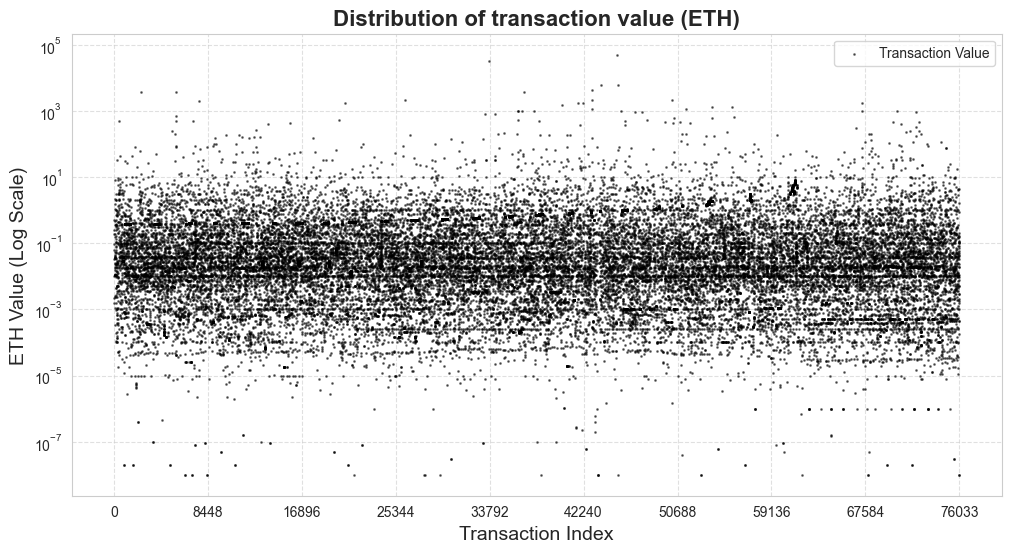

In [8]:
plot_log_scatter(df.index,
                df['value'],
                'Distribution of transaction value (ETH)',
                'Transaction Index',
                'ETH Value (Log Scale)')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


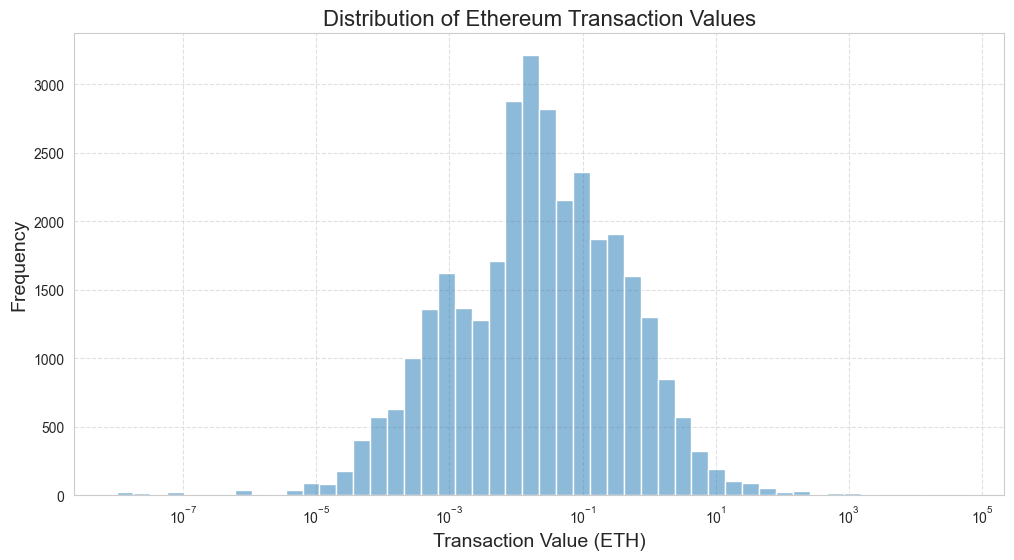

In [9]:
plt.figure(figsize=(12, 6))

sns.histplot(df['value'], bins=50, log_scale=True, kde=True)

plt.xlabel("Transaction Value (ETH)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Ethereum Transaction Values", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


The values of these transactions in ETH is actually fairly normal, and the mass seems to lean a bit heavier on the right side than the left side. We can see that there are actually just as many outliers on the left (possibly more) than there are on the right.

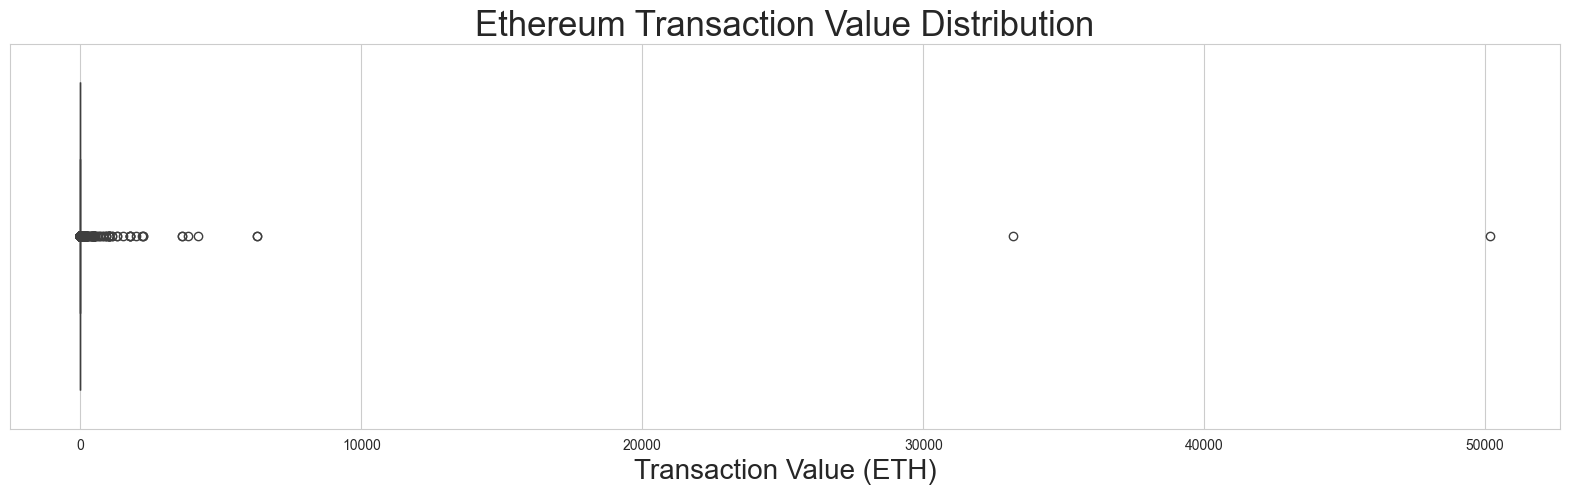

In [10]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['value'], showfliers=True)

plt.xlabel("Transaction Value (ETH)", fontsize=20)
plt.title("Ethereum Transaction Value Distribution", fontsize=25)
plt.show()

Lets fine out where our outliers are (for the larger transactions)

In [11]:
def find_outliers(data, threshhold):
    zscores = stats.zscore(data)
    return np.where(zscores >= threshhold)[0]

outliers_gt_2 = find_outliers(df['value'], 2)
outliers_gt_3 = find_outliers(df['value'], 3)

outliers_gt_2_val = df['value'][outliers_gt_2].sort_values()
outliers_gt_3_val = df['value'][outliers_gt_3].sort_values()

In [14]:
print(f'Number of transactions with a Z-score of 2 or higher: {len(outliers_gt_2_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 2:\n {outliers_gt_2_val}')

Number of transactions with a Z-score of 2 or higher: 48
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 2:
 72399      450.403953
50944      465.999928
70027      466.000000
38189      499.320000
498        499.440000
45938      499.500000
5555       499.759816
7111       499.760000
20249      520.000000
36355      521.999843
47897      522.000000
53754      600.527052
50365      612.706523
55726      677.950000
5556       681.964490
34229      799.999300
33347      800.760000
46828      898.004042
47505      898.004078
72142      921.531963
36324      998.819958
37817      999.998500
36658     1000.000000
67298     1006.392021
70419     1006.393500
36320     1012.747727
45630     1012.748200
43008     1109.007218
51449     1109.007556
53744     1289.999929
55611     1290.000000
40255     1520.615121
41773     1749.462023
42161     1749.462143
20759     1775.000000
67301     1778.999099
7625      1963.000000
26

In [13]:
print(f'Number of transactions with a Z-score of 3 or higher: {len(outliers_gt_3_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 3:\n {outliers_gt_3_val}')

Number of transactions with a Z-score of 3 or higher: 35
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 3:
 55726      677.950000
5556       681.964490
34229      799.999300
33347      800.760000
46828      898.004042
47505      898.004078
72142      921.531963
36324      998.819958
37817      999.998500
36658     1000.000000
67298     1006.392021
70419     1006.393500
36320     1012.747727
45630     1012.748200
43008     1109.007218
51449     1109.007556
53744     1289.999929
55611     1290.000000
40255     1520.615121
41773     1749.462023
42161     1749.462143
20759     1775.000000
67301     1778.999099
7625      1963.000000
26178     2204.000000
43011     2218.109828
50175     2218.110000
5552      3626.998570
2405      3627.000000
36907     3841.000000
43024     4194.999811
43811     6291.495993
45329     6291.545993
33744    33183.511741
45248    50156.239046
Name: value, dtype: float64
